In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('training_set_rel3.tsv', sep='\t')

In [4]:
# Drop all rows with missing values and unnecessary features
df = df.dropna(axis = 1)
df = df.drop('rater1_domain1', 1)
df = df.drop('rater2_domain1', 1)
df = df.drop('essay_id', 1)

In [5]:
#Change the scores to a range of 0 to 1
essay_sets = np.unique(df['essay_set'])

for set_no in essay_sets:
    indices = df[df['essay_set'] == set_no].index.tolist()
    grade_max = np.max(df.loc[indices, 'domain1_score'])
    grade_min = np.min(df.loc[indices, 'domain1_score'])
    df.loc[indices, 'domain1_score_12'] = (df.loc[indices, 'domain1_score'] - grade_min)/(grade_max - grade_min)

In [6]:
#Generate column with corresponding grade for essay set
grades = [8,10,10,10,8,10,7,10]
df['grade'] = df['essay_set'].apply(lambda x: grades[x-1])

In [8]:
import nltk
from nltk.corpus import stopwords

def essay_to_wordlist(e, remove_stopwords):
    e = re.sub("[^a-zA-Z@0-9]", " ", e)
    words = e.lower().split()    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

In [9]:
df['wordlist'] = df['essay'].apply(lambda x: essay_to_wordlist(x,False))
df['wordlist_no_stop'] = df['essay'].apply(lambda x: essay_to_wordlist(x,True))

In [10]:
df['essay_length'] = df['wordlist'].apply(lambda x: len(x))
df['essay_length_no_stop'] = df['wordlist_no_stop'].apply(lambda x: len(x))

In [11]:
df['average_word_length'] = df['wordlist'].apply(lambda x:sum(len(word) for word in x) / len(x))

In [12]:
df['unique_words'] = df['wordlist'].apply(lambda x: len(set(x)))
df['percent_unique'] = df['unique_words'] / df['essay_length']

<AxesSubplot:>

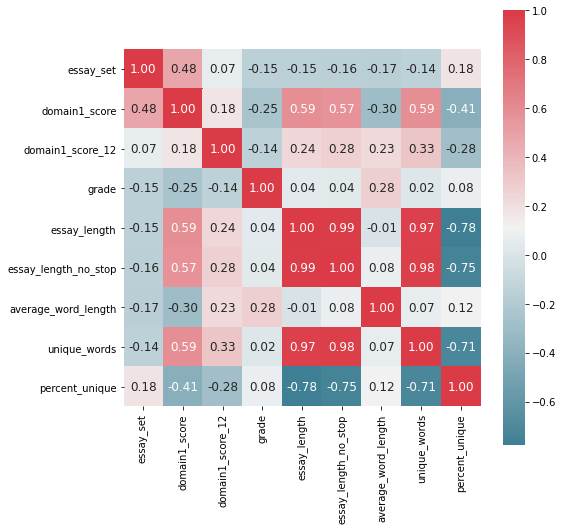

In [13]:
# Generate correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(8,8))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix, cbar=True, square= True,fmt='.2f', annot=True, annot_kws={'size':12},cmap=cmap)

In [19]:
columns = ['essay_length','average_word_length','unique_words','grade','percent_unique','essay_length_no_stop']
df_train = df[columns]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train)
df_train = scaler.transform(df_train)

In [20]:
# Perform train test split
from sklearn.model_selection import train_test_split

X = df_train
y = df['domain1_score_12'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,cohen_kappa_score

## Regression Models

In [18]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)

y_pred = linreg.predict(X_test)


test1 = [round(x) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.4172753957675264
Kappa: 0.4650160689202295


In [19]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)

y_pred = lasso.predict(X_test)

test1 = [round(x) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.900108918840845
Kappa: 0.0


In [20]:
ridge = linear_model.Ridge(alpha=0.05).fit(X_train, y_train)

y_pred = ridge.predict(X_test)

test1 = [round(x) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.4176737536410253
Kappa: 0.46486090553143566


In [21]:
from sklearn.svm import SVR

svm = SVR(kernel='linear').fit(X_train, y_train)

y_pred = svm.predict(X_test)

test1 = [round(x) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.42117647675403
Kappa: 0.45197885571711416


In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf.predict(X_test)

test1 = [round(x) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.118685669853489
Kappa: 0.6502114882825335


## Neural Networks

In [72]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

print(tf.__version__)

2.4.1


In [47]:
model = Sequential()
model.add(Dense(8, input_dim=len(X_train[0]), kernel_initializer='normal', activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_33 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 17,849
Trainable params: 17,849
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train,verbose=1, epochs=30)
predictions = model.predict(X_test)

Epoch 1/30
325/325 [==============================] - 1s 1ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1265
Epoch 2/30
325/325 [==============================] - 0s 948us/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1287
Epoch 3/30
325/325 [==============================] - 0s 930us/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1261
Epoch 4/30
325/325 [==============================] - 0s 926us/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1262 0s - loss: 0.0293 - mse: 0.0293 - mae: 0.
Epoch 5/30
325/325 [==============================] - 0s 920us/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1241
Epoch 6/30
325/325 [==============================] - 0s 914us/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1272
Epoch 7/30
325/325 [==============================] - 0s 914us/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1261
Epoch 8/30
325/325 [==============================] - 0s 945us/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1255 0s - loss: 0.0292 - mse: 0.0292 - mae: 0
Epoch 9/30
325/325 [===========

In [40]:
y_pred = model.predict(X_test)

test1 = [round(x[0]) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.089024071581917
Kappa: 0.6568369139652346


## Word2Vec

## TF-IDF Vector For Neural Network

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [217]:
corpus = df['essay'].values

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus).todense()
y = df['domain1_score_12'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation

from keras.optimizers import Adadelta,Adam,RMSprop

from keras.utils import np_utils

In [1]:
# Definition hyper parameters

np.random.seed(1337)

nb_classes = 20
batch_size = 64
nb_epochs = 35

NameError: name 'np' is not defined

In [218]:
model = Sequential()

model.add(Dense(1000,input_shape= (X_train[0].size,)))
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

print (model.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 1000)              38171000  
_________________________________________________________________
dense_104 (Dense)            (None, 128)               128128    
_________________________________________________________________
dense_105 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 129       
Total params: 38,315,769
Trainable params: 38,315,769
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs,verbose=1)

Epoch 1/100
82/82 [==============================] - 16s 175ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1618
Epoch 2/100
82/82 [==============================] - 14s 171ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0978
Epoch 3/100
82/82 [==============================] - 14s 171ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0722
Epoch 4/100
82/82 [==============================] - 14s 171ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0571
Epoch 5/100
82/82 [==============================] - 14s 167ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0461
Epoch 6/100
82/82 [==============================] - 14s 165ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0352
Epoch 7/100
82/82 [==============================] - 14s 167ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0271
Epoch 8/100
82/82 [==============================] - 14s 168ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0221
Epoch 9/100
82/82 [==============================] - 13s 162ms/step - loss: 7.4458e-04 - mse: 7.4458e-04 - mae: 

In [104]:
y_pred = model.predict(X_test)

test1 = [round(x[0]) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.0916961069921616
Kappa: 0.6847790646167917


### LSTM

In [24]:
from keras.layers import LSTM

In [67]:
df.head()

,essay_set,essay,domain1_score,domain1_score_12,grade,wordlist,wordlist_no_stop,essay_length,essay_length_no_stop,average_word_length,unique_words,percent_unique
0,1,"Dear local newspaper, I think effects computer...",8,0.6,8,"[dear, local, newspaper, i, think, effects, co...","[dear, local, newspaper, think, effects, compu...",350,166,4.251429,166,0.474286
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.7,8,"[dear, @caps1, @caps2, i, believe, that, using...","[dear, @caps1, @caps2, believe, using, compute...",423,224,4.335697,196,0.463357
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.5,8,"[dear, @caps1, @caps2, @caps3, more, and, more...","[dear, @caps1, @caps2, @caps3, people, use, co...",283,136,4.367491,151,0.533569
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.8,8,"[dear, local, newspaper, @caps1, i, have, foun...","[dear, local, newspaper, @caps1, found, many, ...",530,302,4.890566,251,0.473585
4,1,"Dear @LOCATION1, I know having computers has a...",8,0.6,8,"[dear, @location1, i, know, having, computers,...","[dear, @location1, know, computers, positive, ...",473,224,4.342495,201,0.424947


In [68]:
corpus = []
for li in df['wordlist_no_stop'].values:
    essay = ' '.join(li)
    corpus.append(essay)

In [101]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout,Embedding

In [75]:
voc_size=5000

In [83]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
embedded_docs=pad_sequences(onehot_repr)

In [85]:
print(len(embedded_docs[1]))

524


In [109]:
embedding_vector_features=300
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=len(embedded_docs[0])))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam',metrics=['mse','mae'])

In [110]:
X_final=np.array(embedded_docs)
y_final=np.array(df['domain1_score_12'].values)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=0)

In [111]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
163/163 [==============================] - 122s 741ms/step - loss: 0.0999 - mse: 0.0999 - mae: 0.2377 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1278
Epoch 2/10
163/163 [==============================] - 142s 871ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1226 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1329
Epoch 3/10
163/163 [==============================] - 130s 801ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.1085 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1260
Epoch 4/10
163/163 [==============================] - 136s 836ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0989 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1301
Epoch 5/10
163/163 [==============================] - 141s 865ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0945 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1296
Epoch 6/10
163/163 [==============================] - 140s 858ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0838 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae:

In [97]:
y_pred = model.predict(X_test)

test1 = [round(x[0]) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.149909519004823
Kappa: 0.7101831692302906


In [112]:
y_pred = model.predict(X_test)

test1 = [round(x[0]) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 2.1567073860040393
Kappa: 0.6783560649572848


In [62]:
model = Sequential()

model.add(LSTM(128, input_shape=(1,X_train[0].size) , activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 128)            19609088  
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [66]:
model.fit(X_train,y_train,epochs=3)

Epoch 1/3


ValueError: in user code:

    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\shinp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:223 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_11 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 38170)


In [64]:
X_train = X_train.reshape(1,X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1])

In [65]:
X_train.shape

(10380, 38170)

In [22]:
np.__version__

'1.19.5'

In [44]:
X_train[0].size

38170

## Neural Net with Doc2Vec

In [196]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['wordlist'].values)]
model_doc2vec = Doc2Vec(documents, vector_size=300, window=2, min_count=1)

In [197]:
X = np.array([model_doc2vec.infer_vector(x) for x in df['wordlist'].values])

In [198]:
y = df['domain1_score_12'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [199]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

10380
2596
10380
2596


In [210]:
# Definition hyper parameters

np.random.seed(1337)

nb_classes = 20
batch_size = 128
nb_epochs = 100

In [214]:
model = Sequential()

model.add(Dense(256,input_shape= (len(X_train[0]),)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

print (model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 256)               77056     
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_82 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)               

In [215]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs,verbose=1)

Epoch 1/100
82/82 [==============================] - 1s 3ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1659
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1330
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0283 - mse: 0.0283 - mae: 0.1300
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1268
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1241
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1229
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0246 - mse: 0.0246 - mae: 0.1207
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1192
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1169
Epoch 10/100
82/82 [========

In [216]:
y_pred = model.predict(X_test)

test1 = [round(x[0]) for x in 12*y_pred]
test2 = [round(x) for x in 12*y_test]

error = mean_squared_error(test1,test2,squared=False)

print('RMSE: '+str(error))

kappa = cohen_kappa_score(test2,test1,weights='quadratic')

print('Kappa: '+str(kappa))

RMSE: 1.9830755401251954
Kappa: 0.7253215437682752
